In [1]:
import sys
import pathlib

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [86]:
sys.path.append("..")
from src.preprocess import preprocess, discrete_timestep
from src.utils import WorldDefinition, assign_color, point_to_bbox
from src.visualize import visualize_objects, ObjectVisualization

In [87]:
FREQUENCY = 30
DURATION = 30

In [88]:
data_path = "../data/raw/rdb1.parquet"
df = pd.read_parquet(data_path)

In [89]:
df = df[df["table"] == "rdb1_1"]

In [90]:
df["k"] = discrete_timestep(df, FREQUENCY)

In [91]:
df = df[df["k"] < FREQUENCY*DURATION]

In [92]:
df = df.sort_values("k")

In [93]:
gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["UTM_X"], df["UTM_Y"]), crs='EPSG:25832')

In [94]:
gdf["bbox"] = gdf.apply(lambda row:
                            point_to_bbox(row.geometry, row["WIDTH"],
                                          row["LENGTH"],
                                          row["UTM_ANGLE"],
                                          as_linestring=True), axis=1)

In [95]:
gdf = gdf.set_geometry("bbox")

In [96]:
gdf.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k,geometry,bbox
0,0,1,0.0,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1,0,POINT (619302.330 5809133.780),"LINEARRING (619304.426 5809136.353, 619305.648..."
897,897,898,0.0,3,619281.51,5809126.72,3.813485,1.32,0.0693,0.0130,0.0681,Car,1.8667,3.7854,rdb1_1,0,POINT (619281.510 5809126.720),"LINEARRING (619280.610 5809124.811, 619279.448..."
1138,1138,1139,0.0,4,619288.84,5809134.99,4.276385,3.78,0.9199,0.3400,-0.8548,Car,1.7642,4.4819,rdb1_1,0,POINT (619288.840 5809134.990),"LINEARRING (619288.693 5809132.586, 619287.094..."
1424,1424,1425,0.0,5,619316.99,5809146.38,1.354885,4.60,1.3951,-1.2106,0.6932,Medium Vehicle,2.1041,4.8186,rdb1_1,0,POINT (619316.990 5809146.380),"LINEARRING (619316.479 5809148.959, 619318.534..."
1640,1640,1641,0.0,6,619352.15,5809156.25,0.374685,12.77,0.1075,0.1027,-0.0318,Car,2.2045,4.9059,rdb1_1,0,POINT (619352.150 5809156.250),"LINEARRING (619354.029 5809158.174, 619354.836..."


In [97]:
# get traffic lanes
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [98]:
world_def = WorldDefinition.from_pgw_file(pathlib.Path(r'..\data\raw\rdb1\geo-referenced_images_rdb1\rdb1.pgw'))
extent = world_def.get_image_extent(3840, 2160)

In [102]:
gdf["color"] = assign_color(gdf["OBJID"])

In [103]:
gdf.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k,geometry,bbox,color
0,0,1,0.0,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1,0,POINT (619302.330 5809133.780),"LINEARRING (619304.426 5809136.353, 619305.648...",#308774
897,897,898,0.0,3,619281.51,5809126.72,3.813485,1.32,0.0693,0.0130,0.0681,Car,1.8667,3.7854,rdb1_1,0,POINT (619281.510 5809126.720),"LINEARRING (619280.610 5809124.811, 619279.448...",#32D102
1138,1138,1139,0.0,4,619288.84,5809134.99,4.276385,3.78,0.9199,0.3400,-0.8548,Car,1.7642,4.4819,rdb1_1,0,POINT (619288.840 5809134.990),"LINEARRING (619288.693 5809132.586, 619287.094...",#6706D7
1424,1424,1425,0.0,5,619316.99,5809146.38,1.354885,4.60,1.3951,-1.2106,0.6932,Medium Vehicle,2.1041,4.8186,rdb1_1,0,POINT (619316.990 5809146.380),"LINEARRING (619316.479 5809148.959, 619318.534...",#E805DA
1640,1640,1641,0.0,6,619352.15,5809156.25,0.374685,12.77,0.1075,0.1027,-0.0318,Car,2.2045,4.9059,rdb1_1,0,POINT (619352.150 5809156.250),"LINEARRING (619354.029 5809158.174, 619354.836...",#846A32


  0%|          | 0/899 [00:00<?, ?it/s]

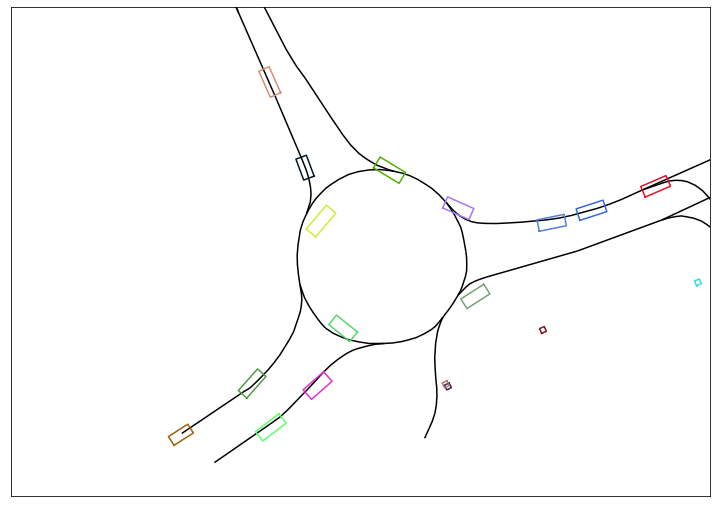

In [101]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor="w")

moviewriter = FFMpegWriter(FREQUENCY)

with moviewriter.saving(fig, 'test.mp4', dpi=200):
    
    for k, timestep_data in tqdm(gdf.groupby("k"), total=gdf["k"].nunique()):
        ax.clear()
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        objects = [ObjectVisualization(i, row["bbox"], color=row["color"]) for i, row in timestep_data.iterrows()]

        visualize_objects(ax, objects, trafficlanes)

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

        moviewriter.grab_frame()